# Import libraries

In [17]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

# Import data

In [18]:
import pandas as pd
df=pd.read_csv('D:\\Programming\\Python\\Codebasics\\deep-learning-keras-tf-tutorial-master\\deep-learning-keras-tf-tutorial-master\\47_BERT_text_classification\\spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [20]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

# Undersampling dataset

In [21]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [22]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [23]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [24]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [25]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [26]:
df_balanced.sample(5)

,Category,Message
1594,spam,PRIVATE! Your 2003 Account Statement for shows...
4407,spam,As one of our registered subscribers u can ent...
1469,spam,Hi its LUCY Hubby at meetins all day Fri & I w...
259,spam,We tried to contact you re your reply to our o...
5344,ham,When you guys planning on coming over?


# Adding target value to dataset

In [27]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
2160,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,1
4311,spam,Someone U know has asked our dating service 2 ...,1
2698,ham,Can you use foreign stamps for whatever you se...,0
1581,ham,"I shall book chez jules for half eight, if tha...",0
4431,ham,Yar lor... How u noe? U used dat route too?,0
1691,spam,Sunshine Quiz Wkly Q! Win a top Sony DVD playe...,1
1225,spam,You are a winner U have been specially selecte...,1
920,ham,Dont talk to him ever ok its my word.,0
2249,ham,will you like to be spoiled? :),0
2694,ham,All these nice new shirts and the only thing I...,0


# Splitting dataset into train and test sets

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [29]:
X_train.head(4)

1853    This is the 2nd time we have tried 2 contact u...
1378    Double Mins & Double Txt & 1/2 price Linerenta...
2000        LMAO where's your fish memory when I need it?
631                   Please dont say like that. Hi hi hi
Name: Message, dtype: object

# Download BERT preprocessor and encoder

In [41]:
bert_encoder=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
bert_preprocess=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

# Testing BERT

In [42]:
def get_sentence_embedding(sentences):
    preprocessed_text=bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    "Hello I am a very good human",
    'My mother is irritating me'
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.86796063, -0.36837634, -0.51555425, ..., -0.3854853 ,
        -0.6287017 ,  0.9033338 ],
       [-0.82976496, -0.22625674,  0.4235747 , ...,  0.32940912,
        -0.5535512 ,  0.8661145 ]], dtype=float32)>

In [43]:
e = get_sentence_embedding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [44]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069146, -0.14219373,  0.49604702, ...,  0.4216537 ,
        -0.5322139 ,  0.80312145],
       [-0.8602323 , -0.2124292 ,  0.49156952, ...,  0.39798045,
        -0.60506296,  0.8447166 ],
       [-0.71288633, -0.15463904,  0.38401708, ...,  0.3527877 ,
        -0.5099134 ,  0.7347411 ],
       [-0.82533467, -0.35550553, -0.5906959 , ..., -0.01613607,
        -0.61417586,  0.87230295],
       [-0.75041354, -0.2681259 , -0.26689678, ...,  0.02839373,
        -0.59380984,  0.7974989 ],
       [-0.7854429 , -0.29949594,  0.41027772, ...,  0.5222558 ,
        -0.49573478,  0.81507415]], dtype=float32)>

# Checking similarity between banana and grapes

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]],[e[1]])

array([[0.99110866]], dtype=float32)

# Create deep learning model

In [49]:
# Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string, name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

# Neural Network Layers
l=tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

# Construct Final Model
model=tf.keras.Model(inputs=[text_input], outputs=[l])

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [54]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS
)

In [55]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 26s 615ms/step - loss: 0.7886 - accuracy: 0.4973 - precision: 0.4969 - recall: 0.4250
Epoch 2/10
35/35 [==============================] - 22s 618ms/step - loss: 0.5939 - accuracy: 0.7205 - precision: 0.7090 - recall: 0.7482
Epoch 3/10
35/35 [==============================] - 22s 620ms/step - loss: 0.5056 - accuracy: 0.8161 - precision: 0.8105 - recall: 0.8250
Epoch 4/10
35/35 [==============================] - 22s 619ms/step - loss: 0.4448 - accuracy: 0.8518 - precision: 0.8362 - recall: 0.8750
Epoch 5/10
35/35 [==============================] - 22s 620ms/step - loss: 0.4150 - accuracy: 0.8589 - precision: 0.8589 - recall: 0.8589
Epoch 6/10
35/35 [==============================] - 22s 622ms/step - loss: 0.3724 - accuracy: 0.8839 - precision: 0.8772 - recall: 0.8929
Epoch 7/10
35/35 [==============================] - 22s 624ms/step - loss: 0.3499 - accuracy: 0.8795 - precision: 0.8657 - recall: 0.8982
Epoch 8/10
35/35 [================

In [56]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 8s 595ms/step - loss: 0.3044 - accuracy: 0.8930 - precision: 0.9061 - recall: 0.8770


[0.3043678104877472, 0.893048107624054, 0.9060773253440857, 0.8770053386688232]

# Checking predictions

In [57]:
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()

12/12 [==============================] - 8s 609ms/step


In [58]:
import numpy as np

y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,

# Plotting confusion matrix

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[170,  17],
       [ 23, 164]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

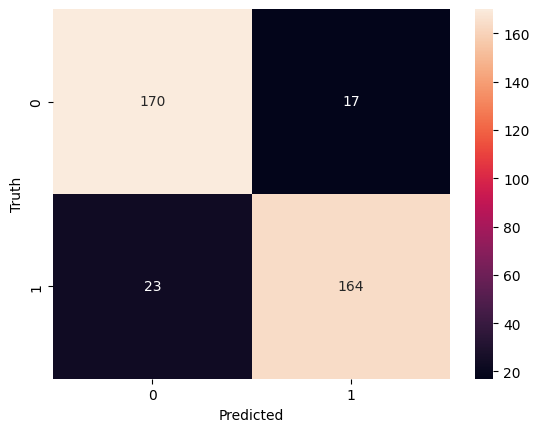

In [61]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       187
           1       0.91      0.88      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



# Testing model

In [63]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.684451  ],
       [0.7492174 ],
       [0.6662787 ],
       [0.13124797],
       [0.07637636]], dtype=float32)